In [3]:
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import os
import shutil
from PIL import Image
from tqdm.notebook import tqdm
import torch.nn as nn
from torchvision import models
import numpy as np
from sklearn.model_selection import train_test_split

**Путь до директории с данными**

In [4]:
root = "/kaggle/input/bhw-1-deep-learning/bhw1-dataset"

## Пишем свой Dataset

In [5]:
class MyDataset(Dataset):
    TEST_SIZE = 0.20
    SPLIT_RANDOM_SEED = 42
    
    def __init__(self, root, final_test=False, final_train=False, train=True, transform=None, load_to_ram=False):
        super().__init__()
        self.root = root
        self.transform = transform
        self.train = train
        self.final_test = final_test
        self.final_train = final_train
        self.load_to_ram = load_to_ram
        self.to_tensor = T.ToTensor()
        self.all_files = []
        self.all_labels = []
        self.images = []
        self.classes = []
        
        if self.final_test:
            self.data_root = self.root + "/test"
        else:
            self.data_root = self.root + "/trainval"
            self.labels_root = self.root + "/labels.csv"
            all_labels = list(pd.read_csv(self.labels_root)['Label'])
        
        
        all_files = sorted(os.listdir(self.data_root))
        
        if not self.final_test and not self.final_train:
            train_files, test_files, train_labels, test_labels = train_test_split(all_files, all_labels, random_state=self.SPLIT_RANDOM_SEED,
                                                       test_size=self.TEST_SIZE)
        
        if self.final_test:
            self.files = all_files
        elif self.final_train:
            self.files = all_files
            self.labels = all_labels
        elif self.train:
            self.files = train_files
            self.labels = train_labels
        else:
            self.files = test_files
            self.labels = test_labels
        
        if not self.final_test:
            self.classes = sorted(pd.unique(all_labels))

        if self.load_to_ram:
            self.images = self._load_images(self.files)

    def _load_images(self, image_files):
        images = []
        for filename in image_files:
            image = Image.open(os.path.join(self.data_root, filename)).convert('RGB')
            images += [image]

        return images

    def __len__(self):
        return len(self.files)

    def __getitem__(self, item):
        if not self.final_test:
            label = self.labels[item]
        filename = self.files[item]
        image = Image.open(os.path.join(self.data_root, filename)).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)
        
        if self.final_test:
            return image
        else:
            return image, label

## Функции для обучения и рисования графиков

In [6]:

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [7]:

def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()
    
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy

    
def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

## Функции для обучения на всей выборке

In [8]:

def train_only(model, optimizer, scheduler, criterion, train_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        
        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        plot_train_loss(train_losses, train_accuracies)

    return train_losses, train_accuracies

def plot_train_loss(train_losses, train_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()
    
def make_predictions(model, test_loader):
    predictions = []
    model.eval()
    for images in tqdm(test_loader):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        logits = model(images)  # logits: batch_size x num_classes
        predictions += (torch.argmax(logits, dim=1).tolist())
        
    return predictions

In [13]:
class BasicBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super(BasicBlock, self).__init__()
        self.is_dims_changed = True
        stride = 2
        self.dropout_percantage = 0.15
        if in_channels == out_channels:
            stride = 1
            self.is_dims_changed = False
            
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.drop = nn.Dropout(p=self.dropout_percantage)
        
        self.dims_change = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        identity = x
        x = self.drop(self.bn2(self.conv2(self.relu1(self.bn1(self.conv1(x))))))
        if self.is_dims_changed:
            identity = self.dims_change(identity)
        x += self.relu2(x + identity)
        return x
    
class StartingBlock(nn.Module):
    def __init__(self, out_channels):
        super(StartingBlock, self).__init__()
        self.conv = nn.Conv2d(3, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
    
class FinalBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FinalBlock, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, num_classes)
        
    def forward(self, x):
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x
        
    
class ResNet18(nn.Module):
    
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.in_channels = 16
        
        self.start = StartingBlock(16)
        
        self.layer1 = self.make_layer(16, 5)
        self.layer2 = self.make_layer(32, 5)
        self.layer3 = self.make_layer(64, 5)
        
        self.final = FinalBlock(64, num_classes)
        
    def make_layer(self, out_channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(BasicBlock(self.in_channels, out_channels))
            self.in_channels = out_channels

        return nn.Sequential(*layers)
    
        
    def forward(self, x):
        x = self.start(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.final(x)
        return x

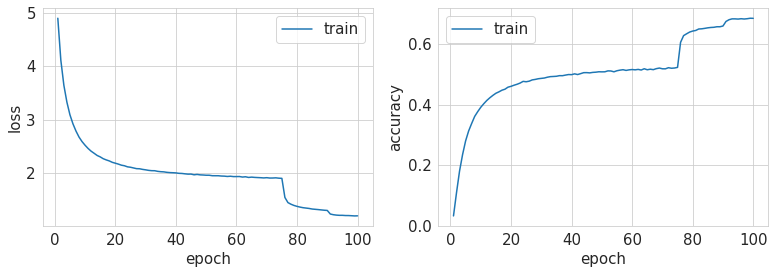

In [14]:
test_transform = T.Compose([
        T.ToTensor(),
        T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

train_transform = test_transform = T.Compose([
        T.RandomCrop(64, 4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

train_dataset = MyDataset(root=root, final_test=False, final_train=True, transform=train_transform, load_to_ram=True)
test_dataset = MyDataset(root=root, final_test=True, final_train=False, transform=test_transform, load_to_ram=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=2)

model = ResNet18(len(train_dataset.classes))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

num_epochs = 100
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 90])

train_losses, train_accuracies = train_only(
    model, optimizer, scheduler, criterion, train_loader, num_epochs
)

In [15]:
predictions = make_predictions(model, test_loader)

  0%|          | 0/79 [00:00<?, ?it/s]

In [17]:
test_files = sorted(os.listdir(root+"/test"))
pd.DataFrame({"Id": test_files, "Label": predictions}).to_csv("/kaggle/working/labels_test_final.csv", index=False)